In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


### Get Data

In [3]:
df2 = pd.read_csv('audio_data3_spectrogram.csv')
# Extract MFCC feature columns
X = df2.iloc[:,4:].values

# Convert labels to numeric numbers (0 for cat, 1 for dog)
y = df2["label"].map({"frog": 0,"donkey": 1,"cat": 2,"monkey": 3,"baby sheep": 4,"bird": 5,"lion": 6,"cow": 7,"dog": 8,"chicken": 9}).values

# First split: train + val and test
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)

# Second split: train and val
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1762, random_state=42, stratify=y_train_val)

# Print the sizes of the splits
print(f'Training set size: {len(X_train)}')
print(f'Validation set size: {len(X_val)}')
print(f'Test set size: {len(X_test)}')

Training set size: 2457
Validation set size: 526
Test set size: 527


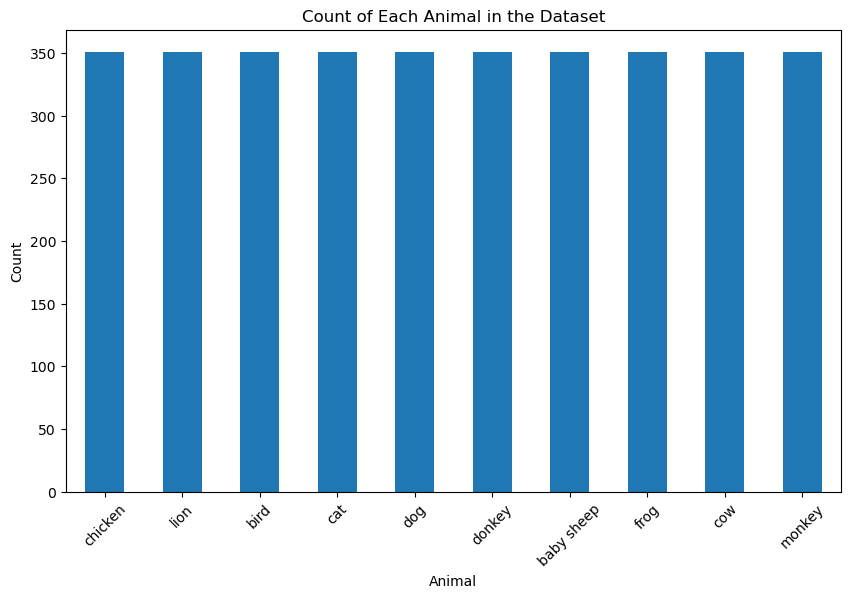

In [4]:
label_counts = df2['label'].value_counts()

# Plot the histogram
plt.figure(figsize=(10, 6))
label_counts.plot(kind='bar')
plt.xlabel('Animal')
plt.ylabel('Count')
plt.title('Count of Each Animal in the Dataset')
plt.xticks(rotation=45)
plt.show()

In [5]:
def reshape_mel_spectrogram(mel_vector, height=114, width=113):
    padded = np.pad(mel_vector, (0, height * width - len(mel_vector)), mode='constant')
    return padded.reshape(height, width)

# Reshape all mel spectrogram data
X_train = np.array([reshape_mel_spectrogram(x) for x in X_train])
X_val = np.array([reshape_mel_spectrogram(x) for x in X_val])
X_test = np.array([reshape_mel_spectrogram(x) for x in X_test])

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)


In [6]:
class SpecDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create datasets
train_dataset = SpecDataset(X_train_tensor, y_train_tensor)
val_dataset = SpecDataset(X_val_tensor, y_val_tensor)
test_dataset = SpecDataset(X_test_tensor, y_test_tensor)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


### Create Model

In [7]:
# Model fo audio_data2
class CNN_Audio2(nn.Module):
    def __init__(self):
        super(CNN_Audio2, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 28 * 28, 128)
        self.fc2 = nn.Linear(128, 10)
    
    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x



### Train Model

In [23]:
model = CNN_Audio2()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 50
train_losses = []
val_losses = []
best_accuracy = 0.0
epochs_without_improvement = 0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs).squeeze(1)  # Ensure outputs are of shape [batch_size]
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_losses.append(running_loss / len(train_loader))

    # Validation loss
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs).squeeze(1)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    val_losses.append(val_loss / len(val_loader))

    # Evaluate on validation set
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total

    # Check for early stopping
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1

    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_losses[-1]}, Validation Loss: {val_losses[-1]}")

print("Training complete!")


Epoch 1/50, Training Loss: 1.4559461048671178, Validation Loss: 0.6977795853334314
Epoch 2/50, Training Loss: 0.3814046863805164, Validation Loss: 0.3082313655930407
Epoch 3/50, Training Loss: 0.13323316256237494, Validation Loss: 0.23584817097905805
Epoch 4/50, Training Loss: 0.058400467104677646, Validation Loss: 0.12206868569859687
Epoch 5/50, Training Loss: 0.020415198943855895, Validation Loss: 0.1375694588812835
Epoch 6/50, Training Loss: 0.03740103853346369, Validation Loss: 0.15342348770183675
Epoch 7/50, Training Loss: 0.01112209214351152, Validation Loss: 0.12310283328406513
Epoch 8/50, Training Loss: 0.002309077351305682, Validation Loss: 0.11840344480279942
Epoch 9/50, Training Loss: 0.001348438019208102, Validation Loss: 0.13927112315671847
Epoch 10/50, Training Loss: 0.001030339912153091, Validation Loss: 0.127075358218623
Epoch 11/50, Training Loss: 0.0007595827454525687, Validation Loss: 0.12627618272466967
Epoch 12/50, Training Loss: 0.0006227287261250925, Validation L

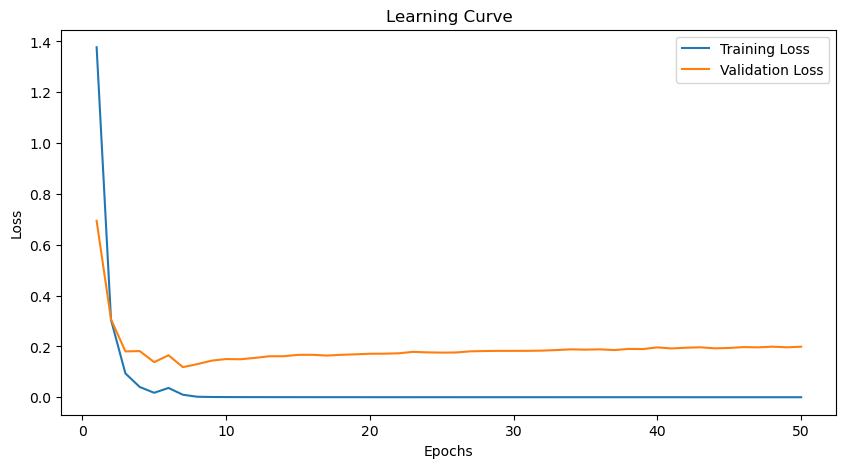

In [9]:
# Plot the learning curve
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()

<Figure size 800x600 with 0 Axes>

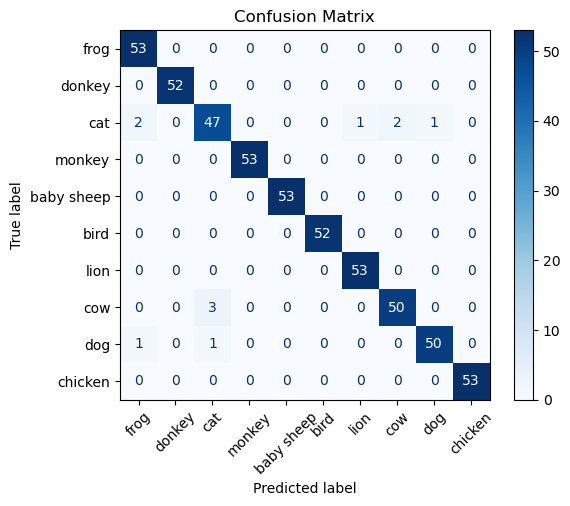

In [25]:
# Evaluate the model on the test set
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.numpy())
        all_labels.extend(labels.numpy())
        
# Compute the confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["frog","donkey","cat","monkey","baby sheep","bird","lion","cow","dog","chicken"])

# Plot the confusion matrix
plt.figure(figsize=(8, 6))  # Increase the figure size
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')

# Rotate the x-axis labels
plt.xticks(rotation=45)

plt.show()

In [26]:
len(y_test)

527

In [27]:
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.numpy())
        all_labels.extend(labels.numpy())

accuracy = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {accuracy}")


Test Accuracy: 0.9791271347248577
